<a href="https://colab.research.google.com/github/Muzzamal-Hameed/Deep-Learning-Models/blob/main/Fake_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ciplab/real-and-fake-face-detection 

 99% 429M/431M [00:04<00:00, 134MB/s]
100% 431M/431M [00:04<00:00, 98.0MB/s]


In [ ]:
!pip install split-folders

In [ ]:
! unzip real-and-fake-face-detection.zip

Archive:  real-and-fake-face-detection.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: real_and_fake_face/training_fake/easy_112_1001.jpg  
  inflating: real_and_fake_face/tr

In [ ]:
import matplotlib.pyplot as plt
import tensorflow 
import numpy as np
import pandas as pd
import cv2
import os
import skimage.io as io
import skimage.transform as tf
import skimage.color as color
import torch

In [ ]:
!pip install haroun==0.1.1

# import my Library (Pytorch Framework)
from haroun import Data, Model, ConvPool
from haroun.augmentation import augmentation
from haroun.losses import rmse

  Created wheel for haroun: filename=Haroun-0.1.1-py3-none-any.whl size=5512 sha256=fc745dda136a5b2ac89c95d4cdf8775bd1c55fb1ed187625242547699fb88fb5
  Stored in directory: /root/.cache/pip/wheels/6d/1a/e5/54ae3689c43bd2391e2228d3cb6bee99cbc6f3c36e2eba7514
Successfully built haroun


In [ ]:
# path = pathlib.Path.cwd().parent / "input" / "real-and-fake-face-detection"
path = "/content/real_and_fake_face"
images = []
labels = []
for directory in os.listdir(path):
  data_path = path +"/"+ directory
  for im in os.listdir(data_path)[:]:
    image = io.imread(f"{data_path}/{im}")
    
    image = tf.resize(image, (64, 64))
    images.append(image)
    if directory == "training_fake":
      labels.append("fake")
    elif directory == "training_real":
      labels.append("real")

In [ ]:
images = np.array(images)
labels = np.array(labels)
images, labels = augmentation(images, labels, flip_y=True, flip_x=True, brightness=True)

In [ ]:
classes = {'real': 0, 'fake': 1}
data = Data(loader=(images, labels), classes=classes)
data.shape()

Data loaded successfully :)
Images shape: (24492, 64, 64, 3) Labels shape: (24492,)



In [ ]:
data.stat()

{'real': 12972, 'fake': 11520}


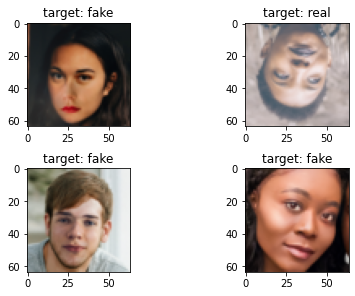

In [ ]:
data.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.dataset(split_size=0.3, shuffle=True, random_state=35,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True, one_hot=True, device=device)

Train tensor shape: torch.Size([17144, 3, 64, 64]), torch.Size([17144, 2])
Test tensor shape: torch.Size([3674, 3, 64, 64]), torch.Size([3674, 2])
Validation tensor shape: torch.Size([3674, 3, 64, 64]), torch.Size([3674, 2])

Dataset generated successfully :)


In [ ]:
class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(3, affine=False)
        self.layer1 = ConvPool(in_features=3, out_features=8)
        self.layer2 = ConvPool(in_features=8, out_features=16)
        self.layer3 = ConvPool(in_features=16, out_features=32)
        self.layer4 = ConvPool(in_features=32, out_features=64)
        self.layer5 = ConvPool(in_features=64, out_features=128)
        self.layer6 = ConvPool(in_features=128, out_features=256)
        
        

        self.net = torch.nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=2)


        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)
        return X

In [ ]:
net = Network()
fakedetector = Model(net, "adam", rmse, device)
fakedetector.train(train_data=(data.train_inputs, data.train_outputs),
                          val_data=(data.val_inputs, data.val_outputs),
                          epochs=100, patience=20, batch_size=128, learning_rate=1.0E-3)

Model initialized succssefully :)

Train loop:

	Epoch: 1/100,  Train Loss: 0.0627,  Val Loss: 0.0599
	Epoch: 2/100,  Train Loss: 0.0573,  Val Loss: 0.0577
	Epoch: 3/100,  Train Loss: 0.0531,  Val Loss: 0.057
	Epoch: 4/100,  Train Loss: 0.0481,  Val Loss: 0.0514
	Epoch: 5/100,  Train Loss: 0.0412,  Val Loss: 0.0468
	Epoch: 6/100,  Train Loss: 0.0349,  Val Loss: 0.0435
	Epoch: 7/100,  Train Loss: 0.0296,  Val Loss: 0.0428
	Epoch: 8/100,  Train Loss: 0.0263,  Val Loss: 0.0378
	Epoch: 9/100,  Train Loss: 0.0241,  Val Loss: 0.0371
	Epoch: 10/100,  Train Loss: 0.0216,  Val Loss: 0.0381 - No improvement -> Remaining patience: 19
	Epoch: 11/100,  Train Loss: 0.0208,  Val Loss: 0.0358
	Epoch: 12/100,  Train Loss: 0.0189,  Val Loss: 0.0355
	Epoch: 13/100,  Train Loss: 0.0173,  Val Loss: 0.034
	Epoch: 14/100,  Train Loss: 0.0174,  Val Loss: 0.035 - No improvement -> Remaining patience: 19
	Epoch: 15/100,  Train Loss: 0.0154,  Val Loss: 0.0335
	Epoch: 16/100,  Train Loss: 0.0156,  Val Loss: 0.031

In [ ]:
fakedetector.evaluate(test_data=(data.test_inputs, data.test_outputs))


Test accuracy:93.8%
Correct predictions: 3446, Wrong predictions: 228


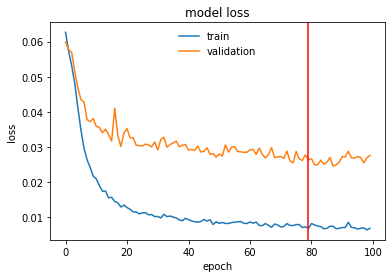


Checkpoint saved successfully :)


In [ ]:
fakedetector.plot()
fakedetector.save(path="./", checkpoint_name="module")

In [ ]:
torch.save(fakedetector, "model_v2.h5")

In [ ]:
fakedetector = torch.load(PATH)
fakedetector.eval()